In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
df = pd.read_csv('saveecobot_17093.csv')
df = df.drop(['value_text'], axis=1)
df.head()

,device_id,phenomenon,value,logged_at
0,17093,pm1,2.57,2021-04-05 17:22:34
1,17093,pm25,3.80,2021-04-05 17:22:34
2,17093,pm10,5.30,2021-04-05 17:22:34
3,17093,pressure_pa,1006570.00,2021-04-05 17:22:34
4,17093,humidity,37.15,2021-04-05 17:22:34


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429749 entries, 0 to 429748
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   429749 non-null  int64  
 1   phenomenon  429749 non-null  object 
 2   value       429749 non-null  float64
 3   logged_at   429749 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 13.1+ MB


In [9]:
df.describe()

,device_id,value
count,429749.0,4.297490e+05
mean,17093.0,1.696547e+05
std,0.0,3.790200e+05
min,17093.0,-1.523000e+01
25%,17093.0,6.280000e+00
50%,17093.0,1.586000e+01
75%,17093.0,7.938000e+01
max,17093.0,1.046940e+06


In [10]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [11]:
df['logged_at'] = pd.to_datetime(df['logged_at'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429749 entries, 0 to 429748
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   device_id   429749 non-null  int64         
 1   phenomenon  429749 non-null  object        
 2   value       429749 non-null  float64       
 3   logged_at   429749 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 13.1+ MB


In [15]:
df.loc[df['phenomenon'] == 'pressure_pa', 'value'] /= 1000

In [16]:
df['phenomenon'] = df['phenomenon'].replace({'pressure_pa': 'pressure_kpa'})

In [20]:
df['hour'] = df['logged_at'].dt.hour
df['month'] = df['logged_at'].dt.month

In [35]:
phenomenons = list(df['phenomenon'].unique())
colors = ['blue', 'yellow', 'grey', 'brown', 'red', 'black']

In [41]:
countOfUniqueFactors = len(phenomenons)
countOfColors = 2
countOfRows = (countOfUniqueFactors + countOfColors - 1) // countOfColors

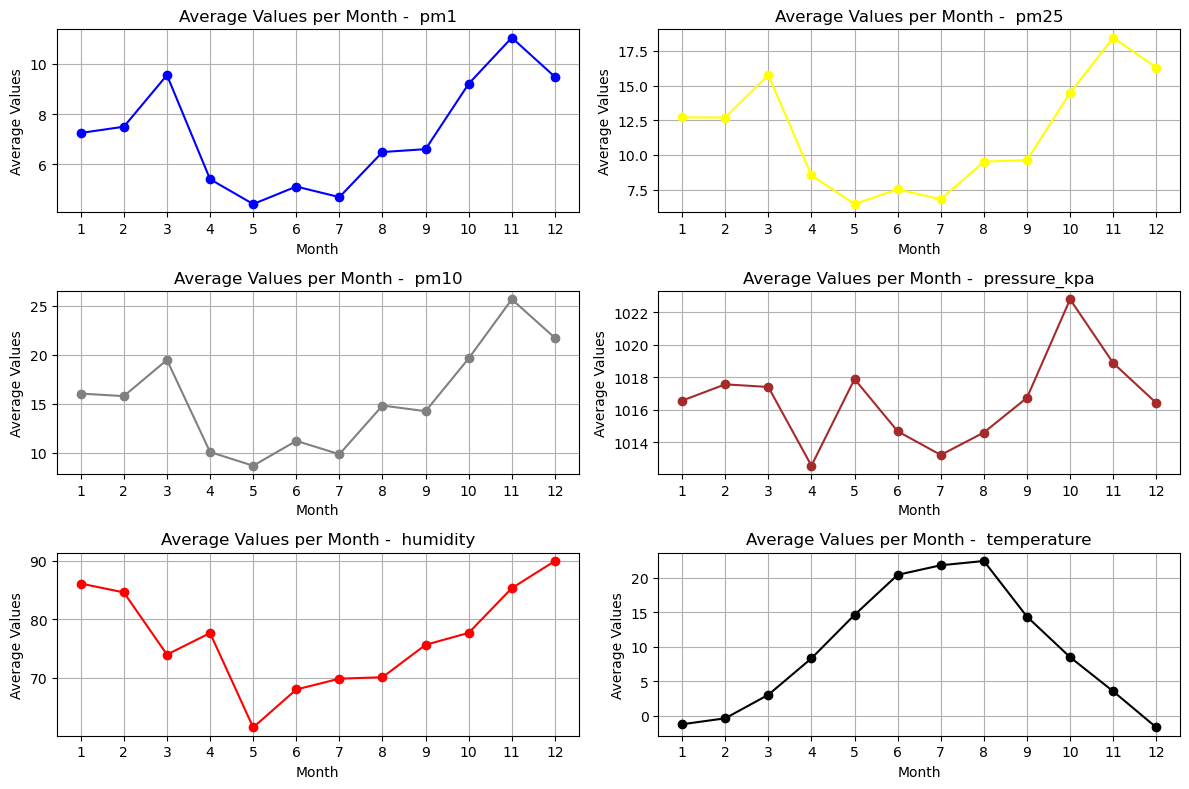

In [62]:
average_values = df.groupby(['phenomenon', 'month'])['value'].mean().reset_index()
fig, axes = plt.subplots(countOfRows, countOfColors, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // countOfColors
    col = i % countOfColors
    ax = axes[row, col]
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['month'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))
    ax.set_facecolor("white")

# for i in range(countOfUniqueFactors, countOfColors * countOfRows):
#     fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

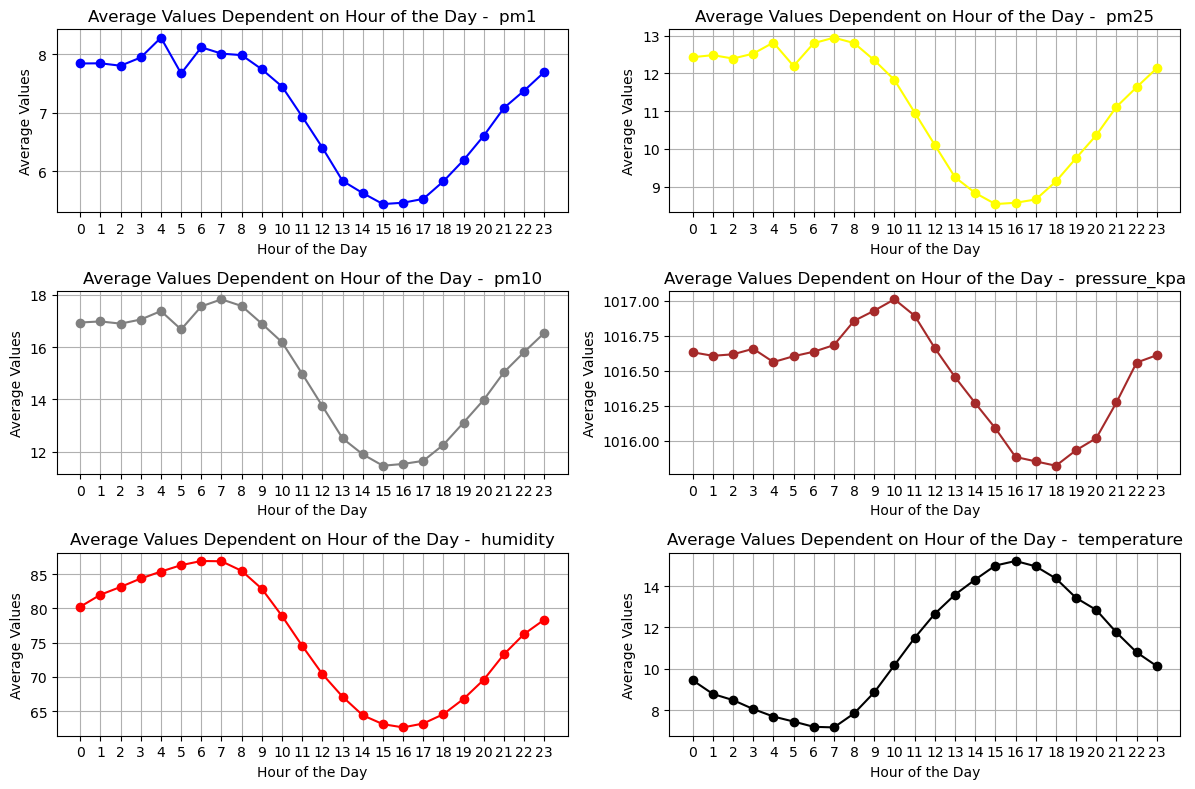

In [64]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].mean().reset_index()
fig, axes = plt.subplots(countOfRows, countOfColors, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // countOfColors
    col = i % countOfColors
    ax = axes[row, col]

    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['hour'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values Dependent on Hour of the Day -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(24))

# for i in range(num_categories, num_cols * num_rows):
#     fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [68]:
countsOfFactors = df['phenomenon'].value_counts()
countOfFactorsList = countsOfFactors.tolist()
entry_counts

pressure_kpa    71720
humidity        71637
temperature     71637
pm1             71585
pm25            71585
pm10            71585
Name: phenomenon, dtype: int64

In [69]:
dfGrouped = df.groupby(['phenomenon', 'logged_at'], as_index=False)['value'].mean()
phenomenon_values = dfGrouped.pivot(index='logged_at', columns='phenomenon', values='value')

phenomenon_values.corr()

phenomenon,humidity,pm1,pm10,pm25,pressure_kpa,temperature
phenomenon,,,,,,
humidity,1.000000,0.210953,0.245944,0.265946,-0.160727,-0.548366
pm1,0.210953,1.000000,0.935065,0.960303,0.085965,-0.181881
pm10,0.245944,0.935065,1.000000,0.984692,0.107714,-0.215962
pm25,0.265946,0.960303,0.984692,1.000000,0.110446,-0.270780
pressure_kpa,-0.160727,0.085965,0.107714,0.110446,1.000000,-0.222370
temperature,-0.548366,-0.181881,-0.215962,-0.270780,-0.222370,1.000000


In [76]:
pm1_df = df[df['phenomenon'] == 'pm1']
pm10_df = df[df['phenomenon'] == 'pm10']
pm1_df = pm1_df.sort_values('hour')
pm10_df = pm10_df.sort_values('hour')
pm1_df

,device_id,phenomenon,value,logged_at,hour,month
315827,17093,pm1,14.63,2023-03-11 00:30:04,0,3
267988,17093,pm1,4.20,2022-12-05 00:45:03,0,12
267982,17093,pm1,4.37,2022-12-05 00:30:03,0,12
267976,17093,pm1,4.54,2022-12-05 00:15:03,0,12
267970,17093,pm1,4.57,2022-12-05 00:00:04,0,12
...,...,...,...,...,...,...
222578,17093,pm1,11.43,2022-09-06 23:15:04,23,9
222572,17093,pm1,11.03,2022-09-06 23:00:03,23,9
303761,17093,pm1,15.67,2023-02-17 23:00:03,23,2
413657,17093,pm1,13.49,2023-08-28 23:15:03,23,8


In [81]:
ts = pm1_df[['logged_at', 'value']].set_index('logged_at')
daily_data = ts['value'].resample('D').mean()
daily_data = daily_data.interpolate(method='linear')
monthly_data = ts['value'].resample('M').mean()
monthly_data = monthly_data.interpolate(method='linear')

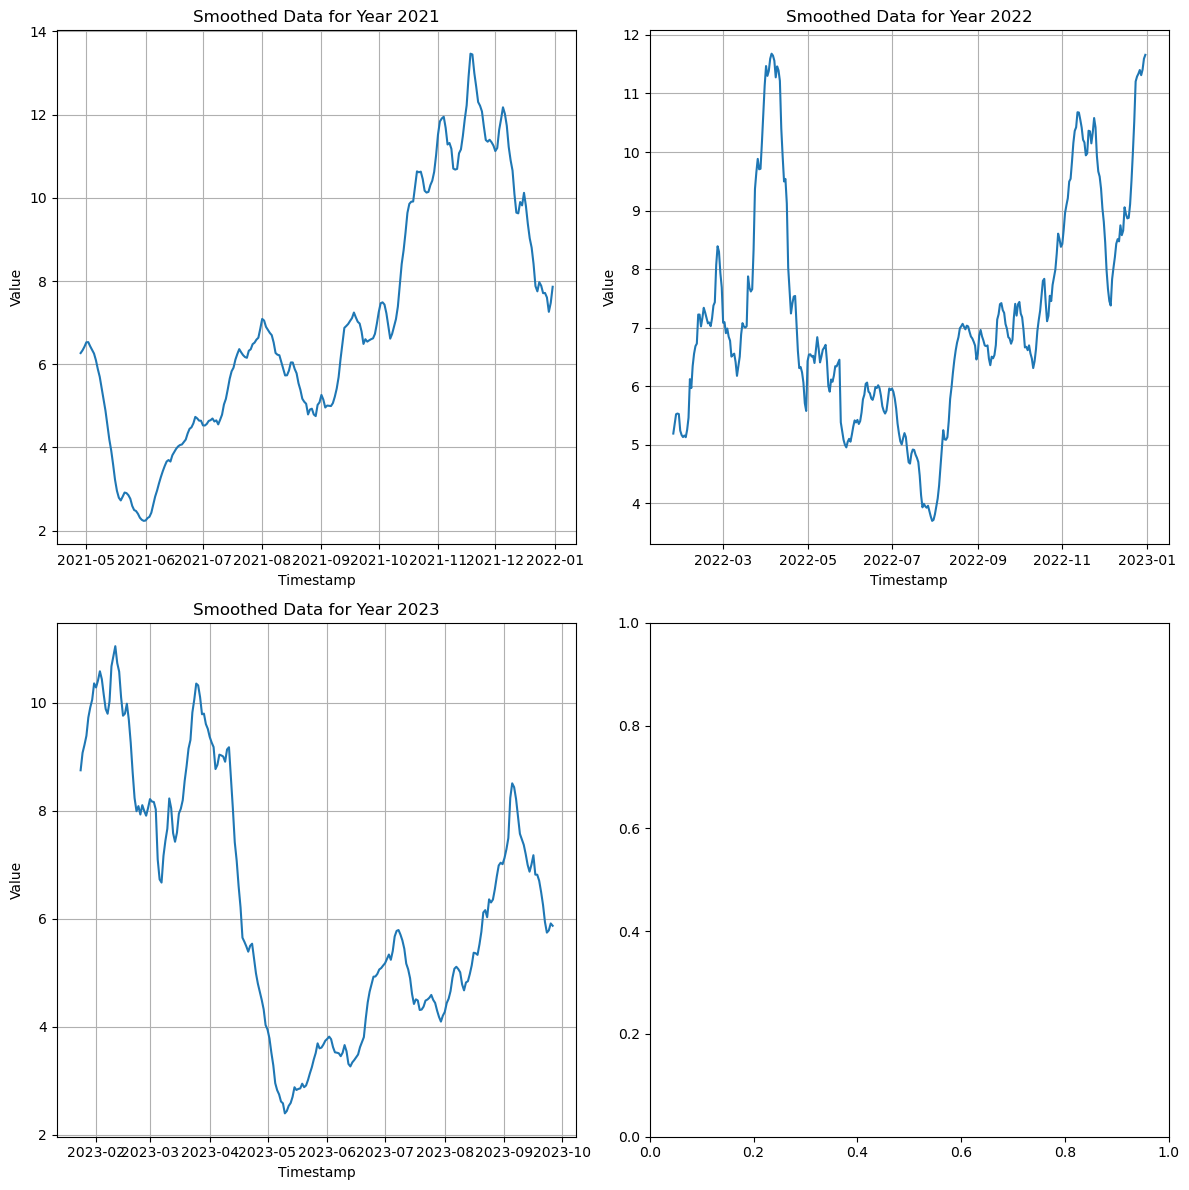

In [90]:
window_size = 24

years = [2021, 2022, 2023]
numberOfYears = len(years)
numberOfRows = (numberOfYears + 1) // 2 
fig, axs = plt.subplots(numberOfRows, 2, figsize=(12, 6 * numberOfRows))

for i, year in enumerate(years):
    row = i // 2
    col = i % 2
    
    year_data = daily_data[str(year)]
    
    smoothed_data = year_data.rolling(window=window_size).mean()
    
    axs[row, col].plot(smoothed_data.index, smoothed_data.values)
    axs[row, col].set_title(f'Smoothed Data for Year {year}')
    axs[row, col].set_xlabel('Timestamp')
    axs[row, col].set_ylabel('Value')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [91]:
X_train = pm1_df.loc[(pm1_df['logged_at'] >= '2021-01-01') & (pm1_df['logged_at'] <= '2022-12-31'), 
                             ['device_id', 'phenomenon', 'value', 'logged_at', 'hour', 'month']]
y_train = pm10_df.loc[(pm10_df['logged_at'] >= '2021-01-01') & (pm10_df['logged_at'] <= '2022-12-31'), 
                             ['device_id', 'phenomenon', 'value', 'logged_at', 'hour', 'month']]
X_test = pm10_df[pm10_df['logged_at'].dt.year == 2023]
y_test = pm10_df[pm10_df['logged_at'].dt.year == 2023]

In [92]:
daily_train_data = daily_data['2022']
daily_test_data = daily_data['2023']

In [93]:
monthly_train_data = monthly_data['2021-01-01':'2022-12-31']
monthly_test_data = monthly_data['2022-12-01':'2023-12-31']

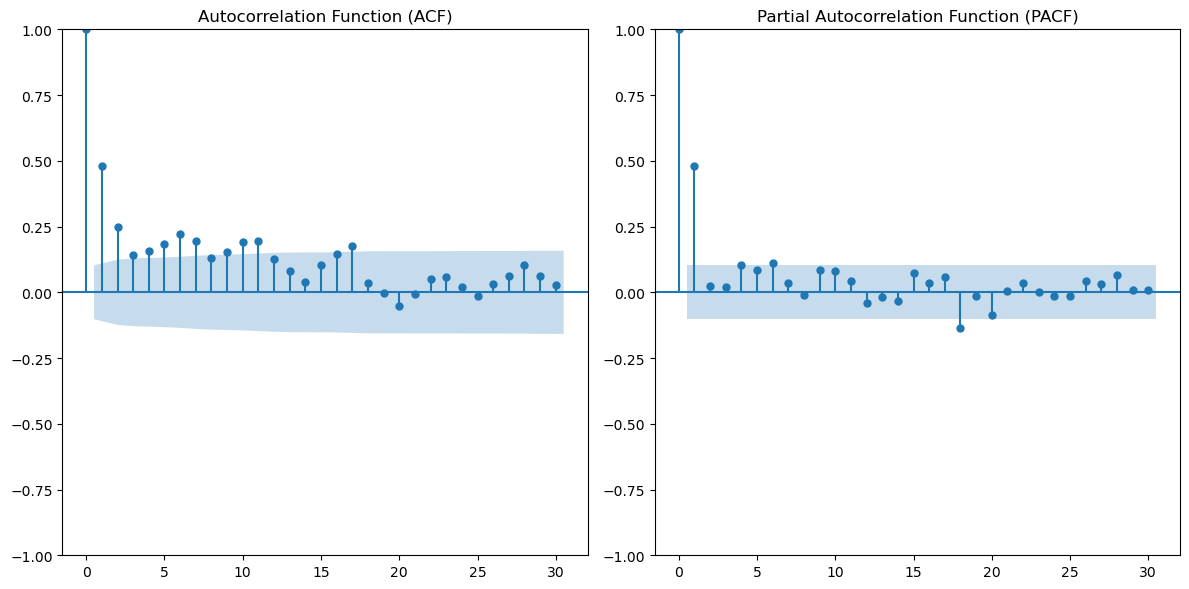

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(daily_train_data, lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_train_data, lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [95]:
p, d, q = 3, 0, 2
model = ARIMA(daily_train_data, order=(p, d, q))
model_fit = model.fit()

/Users/eugene/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/eugene/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/eugene/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [96]:
forecast_steps = len(daily_test_data)
forecast_results = model_fit.predict(start=len(daily_train_data), end=len(daily_train_data) + forecast_steps - 1, typ='levels', dynamic=True)
forecast_values = forecast_results
confidence_intervals = model_fit.get_forecast(steps=forecast_steps).conf_int()
forecast_index = pd.date_range(start='2022-12-01', periods=forecast_steps + len(daily_train_data) - 1, freq='D')
forecast_df = pd.DataFrame({'forecasted_value': forecast_values,
                            'lower_confidence': confidence_intervals.iloc[:, 0],
                            'upper_confidence': confidence_intervals.iloc[:, 1]},
                           index=forecast_index)

/Users/eugene/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


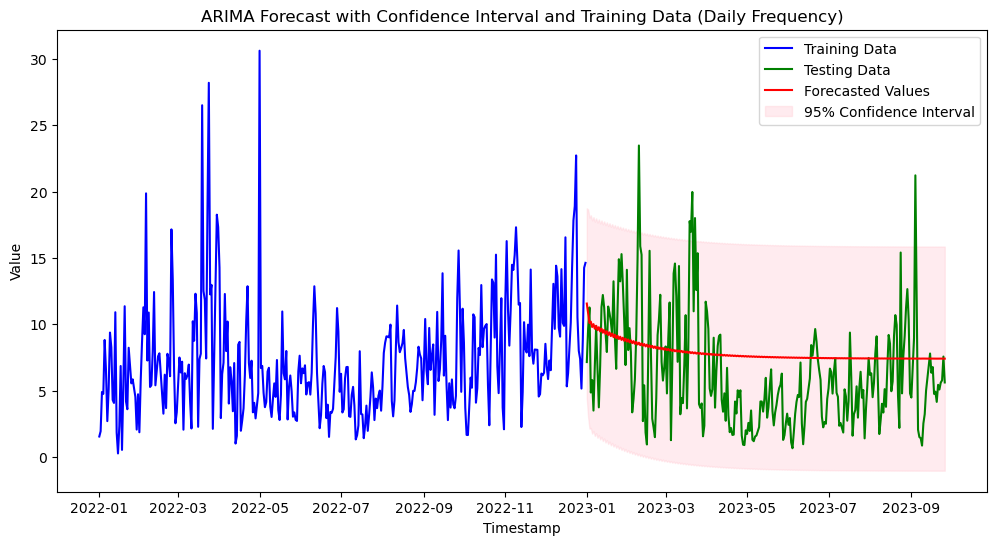

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(daily_train_data, label='Training Data', color='blue')
plt.plot(daily_test_data, label='Testing Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], color='red', label='Forecasted Values')
plt.fill_between(forecast_df.index, forecast_df['lower_confidence'], forecast_df['upper_confidence'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval and Training Data (Daily Frequency)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [98]:
mse = mean_squared_error(daily_test_data, forecast_values)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 4.209030685362967


In [99]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  365
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -992.538
Date:                Fri, 29 Sep 2023   AIC                           1999.076
Time:                        23:01:09   BIC                           2026.376
Sample:                    01-01-2022   HQIC                          2009.926
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4006      1.179      6.274      0.000       5.089       9.712
ar.L1          0.3633      0.062      5.889      0.000       0.242       0.484
ar.L2          0.9628      0.032     30.562      0.000       0.901       1.025
ar.L3         -0.3544      0.055     -6.416      0.000      -0.463      -0.246
ma.L1          0.0729      0.148      0.492      0.623      -0.218       0.363
ma.L2         -0.9263      0.137     -6.762      0.000      -1.195      -0.658
sigma2        13.4175      1.884      7.123      0.000       9.726      17.109
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1066.09
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
X_train = np.array(X_train['value']).reshape(-1, 1)
y_train = np.array(y_train['value']).reshape(-1, 1)
X_test = np.array(X_test['value']).reshape(-1, 1)
y_test = np.array(y_test['value']).reshape(-1, 1)

In [101]:
len(y_train)

46440

In [102]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

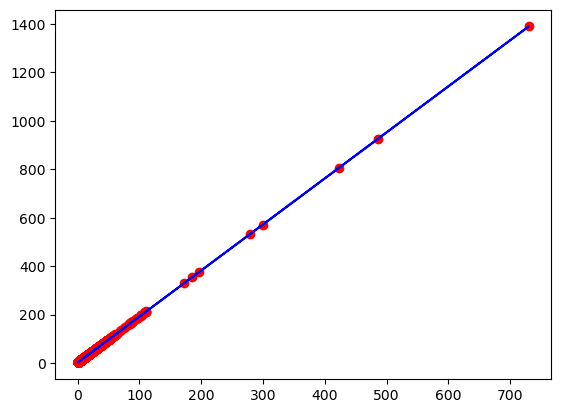

In [103]:
plt.scatter(X_test.flatten(),y_pred.flatten(), color='red') 
plt.plot(X_test, y_pred,color='blue') 

In [104]:
print("Score:", regr.score(X_test, y_test))

Score: -1.0686820526493142


In [105]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 17.614927613373865
